In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model
from pathlib import Path

from warnings import filterwarnings

# Turn off Tensorflow Logs and other tensorflow options
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'
# Surpress warnings related to NaNs
filterwarnings('ignore')

/home/jannik/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Model directory / Network architecture
model_dir = "Surrogate"

# Additional run info
sample_num = 11400

variables = ["Hs", "Tm02", "Dir"]
grid = (160, 160)
convert = True # Is Direction data to be shifted? 
nan_thresholds = [0.1, 0.5, 0.5] # Under which value should be regarded as NaN?

# Save the figure?
save = True

# Load models and data into list
models = []
LRs = []
HRs = []

for var in variables:
    # Load models
    fdir = Path("Models") / model_dir
    fmodel = fdir / f"Model_Inp_{var}.hdf5"
    models.append(load_model(fmodel))

    # Load HR reference for each variable    
    fn_HR = f"Data/Examples/HR/{var}/BaskCoast_{var.upper()}_{sample_num}.npy"
    HRs.append(np.load(fn_HR))
    
# Load spectrum and bathymetry
fname_spec = f'Data/Examples/Spectrum/BaskCoast_{sample_num}.npy'
fname_bat = 'Data/Bathymetry/bat.npy'

X = np.load(fname_spec)
bat = np.load(fname_bat)

# Normalize the input data
X_max, X_min = np.load("Data/Xmax_Xmin_2018_spectrum.npy")
bat_max, bat_min = np.load("Data/bat_max_bat_min_2018_spectrum.npy")

X = (X - X_min) / (X_max - X_min)
bat = (bat - bat_min) / (bat_max - bat_min)

X = X.reshape((1, 32, 24, 1))
bat = bat.reshape((1, 160, 160, 1))

In [4]:
predictions = []
maes = []
nrmses = []
for i in range(len(variables)):
    prediction = (models[i].predict([X, bat])[0,:,:,0])
    prediction[prediction < nan_thresholds[i]] = np.nan
    
    if variables[i] == "Dir" and convert:    
        prediction = (prediction + 255)%360
        
    maes.append(np.nanmean(np.abs(HRs[i] - prediction)))
    nrmses.append(np.sqrt(np.nanmean((HRs[i] - prediction)**2)) 
                  / np.nanmean(HRs[i]) * 100)
    predictions.append(prediction)


1/1 [==============================] - 0s 277ms/step


# Difference Map

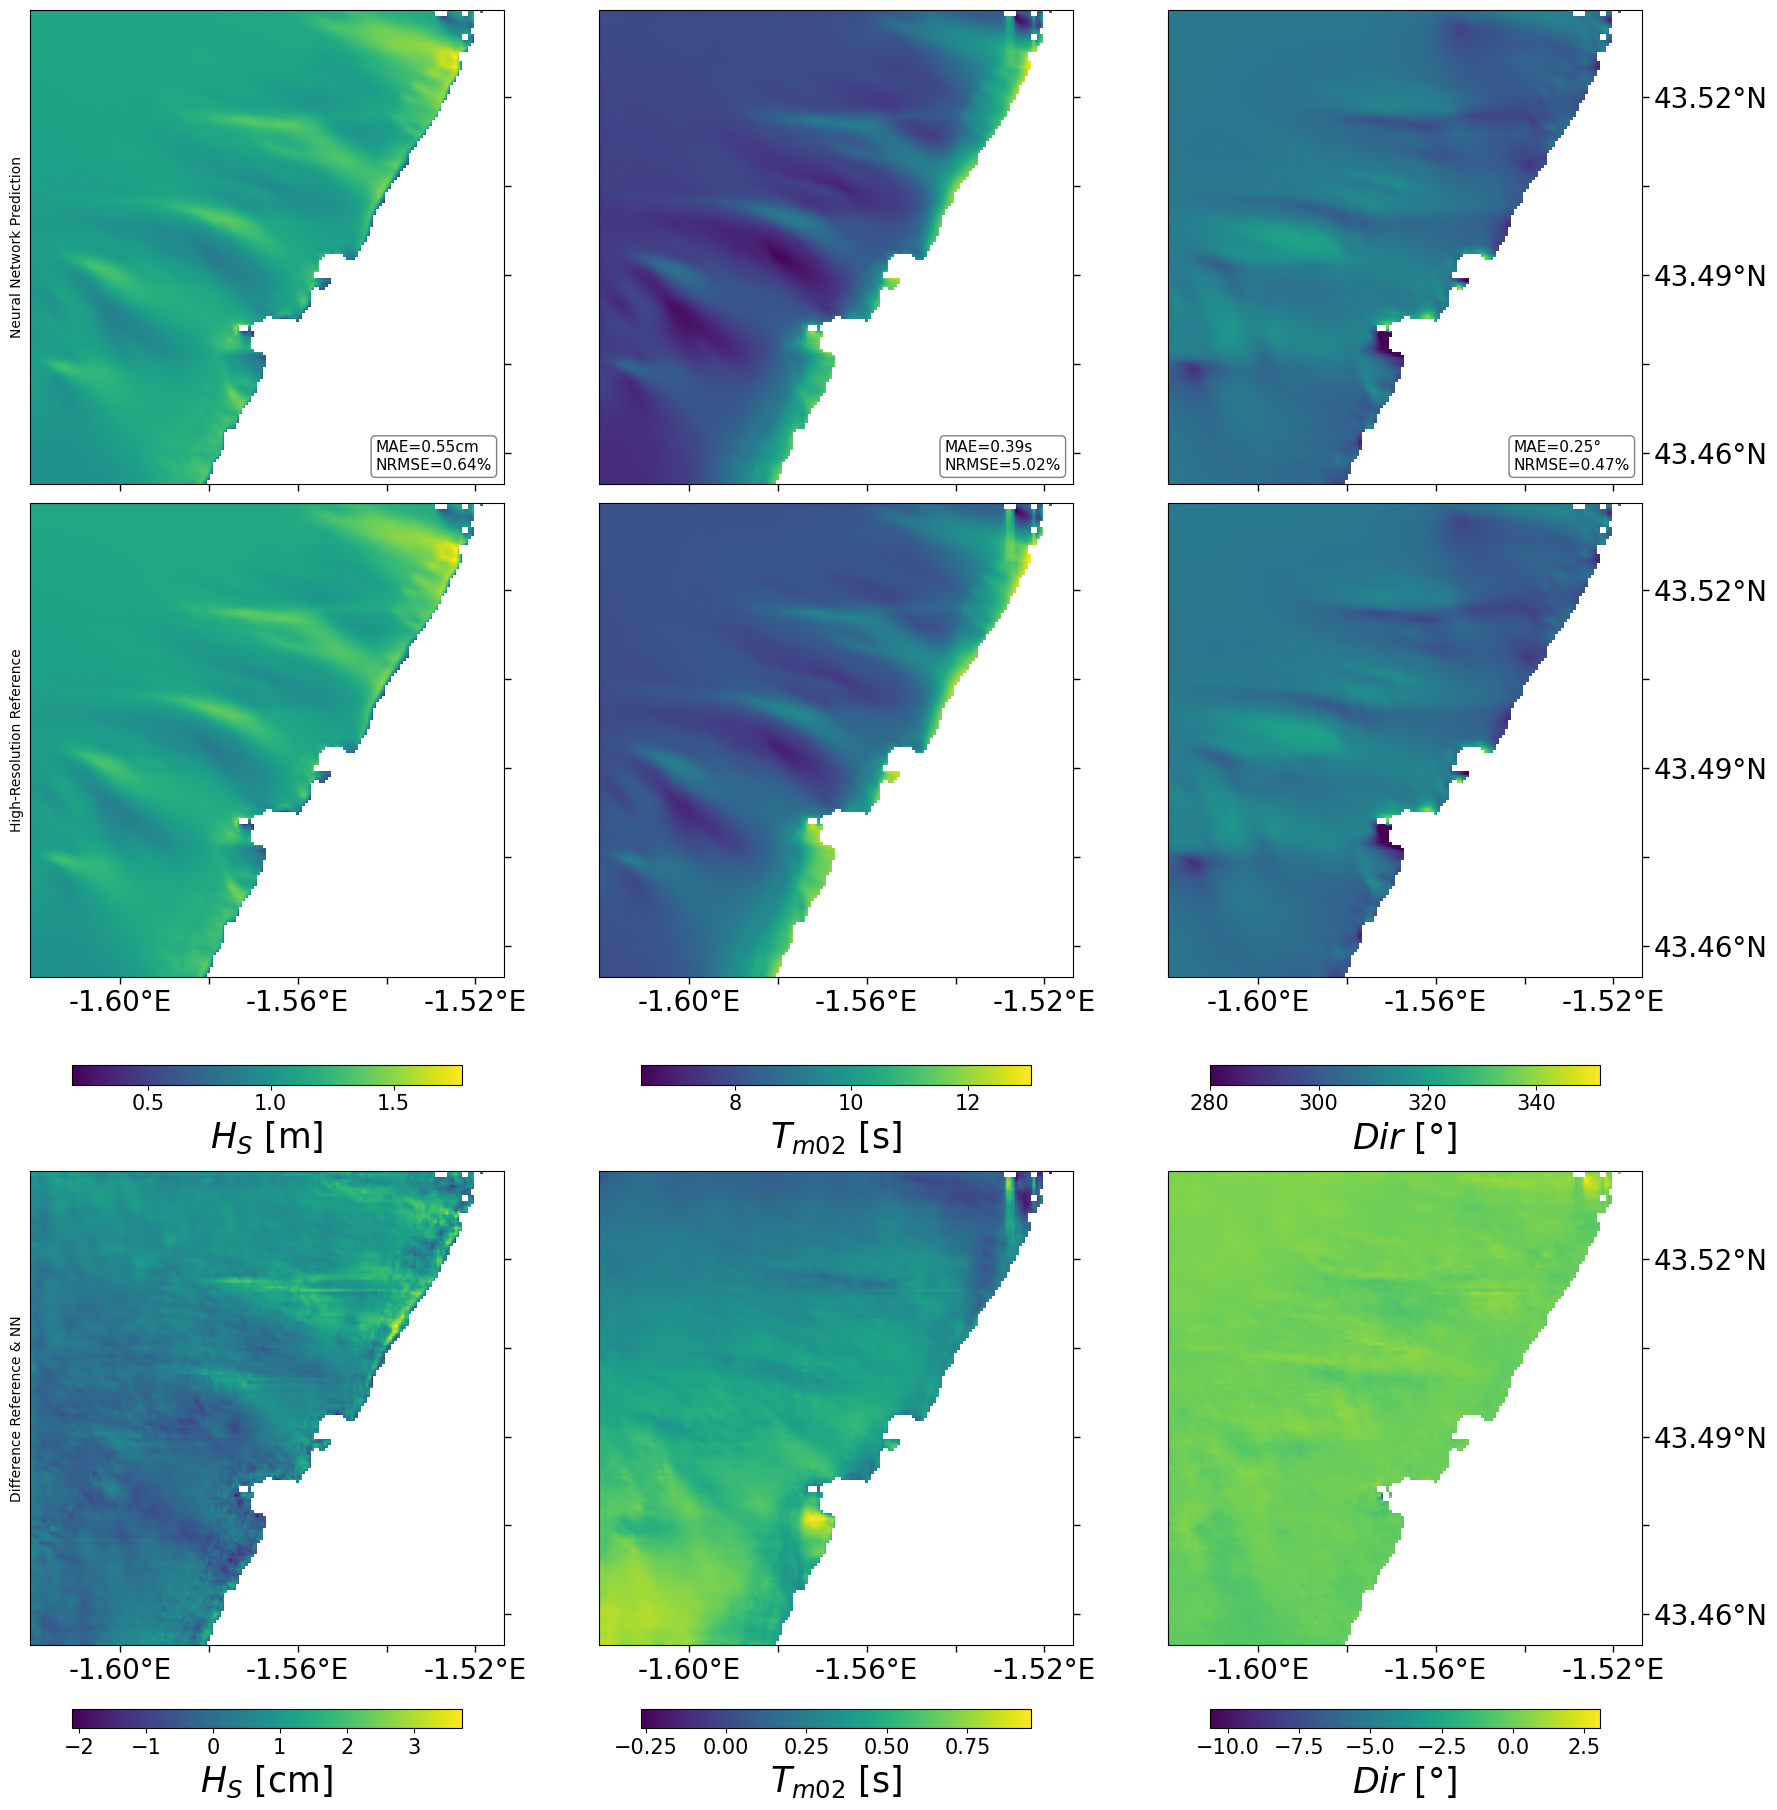

In [5]:
# Define the ranges of longitude and latitude to set up the coordinate system
minlon = -1.617
maxlon = -1.518

minlat = 43.46
maxlat = 43.53


# Format coordinates in a pretty way
x = ["-1.60°E", "", "-1.56°E", "", "-1.52°E"]
y = ["43.46°N", "", "43.49°N", "", "43.52°N"]

# Get the position of the ticks
x_loc = np.arange(30, 160, 30)
y_loc = np.arange(10, 160, 30)


vmin0 = np.nanmin(predictions[0])
vmax0 = np.nanmax(predictions[0])

vmin1 = np.nanmin(predictions[1])
vmax1 = np.nanmax(predictions[1])

vmin2 = 280
vmax2 = np.nanmax(predictions[2])

# Some plotting constants for the ticks
LABELSIZE = 20
LENGTH = 5.0
WIDTH= 1.0
CBAR_LABELSIZE = 15
TEXTSIZE = 11

# Colorbar Properties
CB_BOTTOM = 0.05
CB_WIDTH = 0.25
CB_HEIGHT = 0.01
CB_LEFT0 = 0.04
CB_LEFT1 = 0.35
CB_LEFT2 = 0.67

# Scale the colorbars by which factor
SHRINK = 0.7

cmap = "viridis"

fig, axs = plt.subplots(3, 3, figsize=(18, 18), constrained_layout=True)
plt.rc('axes', labelsize=25) 
plt.rc('axes', titlesize=25)

############################ First row


pos0 = axs[0,0].imshow(predictions[0], cmap=cmap, origin="lower", vmin=vmin0, vmax=vmax0)
text = "\n".join([f"MAE={maes[0]*100:.2f}cm",
                  f"NRMSE={nrmses[0]:.2f}%"]) 
textbox = axs[0, 0].annotate(text, (0.73, 0.03), xycoords="axes fraction",
                             fontsize=TEXTSIZE, bbox=dict(boxstyle="round",
                                                          facecolor='none',
                                                          edgecolor="grey"))
axs[0, 0].set_ylabel("Neural Network Prediction")
axs[0, 0].set_xticks(x_loc)
axs[0, 0].set_yticks(y_loc)
axs[0, 0].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
axs[0, 0].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


pos1 = axs[0,1].imshow(predictions[1], cmap=cmap, origin="lower", vmin=vmin1, vmax=vmax1)
text = "\n".join([f"MAE={maes[1]:.2f}s",
                  f"NRMSE={nrmses[1]:.2f}%"]) 
textbox = axs[0, 1].annotate(text, (0.73, 0.03), xycoords="axes fraction",
                             fontsize=TEXTSIZE, bbox=dict(boxstyle="round",
                                                          facecolor='none',
                                                          edgecolor="grey"))
axs[0, 1].set_xticks(x_loc)
axs[0, 1].set_yticks(y_loc)
axs[0, 1].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
axs[0,1].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


pos2 = axs[0, 2].imshow(predictions[2], cmap=cmap, origin="lower", vmin=vmin2, vmax=vmax2)
text = "\n".join([f"MAE={maes[2]:.2f}°",
                  f"NRMSE={nrmses[2]:.2f}%"]) 
textbox = axs[0, 2].annotate(text, (0.73, 0.03), xycoords="axes fraction",
                             fontsize=TEXTSIZE, bbox=dict(boxstyle="round",
                                                          facecolor='none',
                                                          edgecolor="grey"))
axs[0, 2].set_xticks(x_loc)
axs[0, 2].set_yticks(y_loc)
axs[0, 2].set_yticklabels(y)
axs[0, 2].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
axs[0, 2].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)



############################ Second Row


axs[1, 0].imshow(HRs[0], cmap=cmap, origin="lower", vmin=vmin0, vmax=vmax0)
axs[1, 0].set_xticks(x_loc)
axs[1, 0].set_xticklabels(x)
axs[1, 0].set_yticks(y_loc)
axs[1, 0].set_ylabel("High-Resolution Reference")
axs[1, 0].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=True)
axs[1, 0].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

cbar = fig.colorbar(pos0, ax=axs[:2, 0], orientation="horizontal", label=r"$H_S$ [m]",
             pad=0.05, shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)

axs[1, 1].imshow(HRs[1], cmap=cmap, origin="lower", vmin=vmin1, vmax=vmax1)
axs[1, 1].set_xticks(x_loc)
axs[1, 1].set_xticklabels(x)
axs[1, 1].set_yticks(y_loc)
axs[1, 1].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=True)
axs[1, 1].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

cbar = fig.colorbar(pos1, ax=axs[:2,1], orientation="horizontal", label=r"$T_{m02}$ [s]", shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)

axs[1, 2].imshow(HRs[2], cmap=cmap, origin="lower", vmin=vmin2, vmax=vmax2)
axs[1, 2].set_xticks(x_loc)
axs[1, 2].set_xticklabels(x)
axs[1, 2].set_yticks(y_loc)
axs[1, 2].set_yticklabels(y)
axs[1, 2].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
axs[1, 2].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


cbar = fig.colorbar(pos2, ax=axs[:2,2], orientation="horizontal", label=r"$Dir$ [°]", shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)

####################### Fourth Row (Difference maps)
pos3 = axs[2,0].imshow((HRs[0] - predictions[0])*100, cmap=cmap, origin="lower")
axs[2,0].set_xticks(x_loc)
axs[2,0].set_xticklabels(x)
axs[2,0].set_yticks(y_loc)
axs[2,0].set_ylabel("Difference Reference & NN")
axs[2,0].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=True)
axs[2,0].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


cbar = fig.colorbar(pos3, ax=[axs[2,0]], orientation="horizontal", label=r"$H_S$ [cm]", shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)


pos4 = axs[2, 1].imshow(HRs[1] - predictions[1], cmap=cmap, origin="lower")
axs[2, 1].set_xticks(x_loc)
axs[2, 1].set_xticklabels(x)
axs[2, 1].set_yticks(y_loc)
axs[2, 1].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                    labelleft=False, labeltop=False, labelright=False, labelbottom=True)
axs[2, 1].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

cbar = fig.colorbar(pos4, ax=[axs[2, 1]], orientation="horizontal", label=r"$T_{m02}$ [s]", shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)

diff = HRs[2] - predictions[2]
diff[np.abs(diff) > 50] = np.nan
pos5 = axs[2, 2].imshow(diff, cmap=cmap, origin="lower")
axs[2, 2].set_xticks(x_loc)
axs[2, 2].set_xticklabels(x)
axs[2, 2].set_yticks(y_loc)
axs[2, 2].set_yticklabels(y)
axs[2, 2].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
axs[2, 2].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


cbar = fig.colorbar(pos5, ax=[axs[2, 2]], orientation="horizontal", label=r"$Dir$ [°]", shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)


fdir = Path("Plots")
fname = f"MainPlot_{var}_Mod_{model_dir}_DS_{sample_num}.png"

if save:
    fdir.mkdir(parents=True, exist_ok=True)
    plt.savefig(os.path.join(fdir, fname))
                         
plt.show()